# Fitting weighted histograms with SPD method

We test different fit methods of weighted binned data. The tested weight distributions are normal, exponential, and uniform. The toy case is a common HEP fit of a gaussian peak above a smooth background (here exponential). 

Fits of weighted data are discussed in F. James, "Statistical Methods in Experimental Physics" (2nd edition), World Scientific, in section 8.5. Two approximate least-squares methods for binned data are presented in section 8.5.4. Here we test the method $Q_1'$.

[Bohm and Zech (2014)](https://arxiv.org/abs/1309.1287) derived an approximate maximum-likelihood method for weighted histograms with on average positive weights. The authors show that their approximation yields less biased results than the aforementioned least-squares method. 

Still, a notable bias is present even when the SPD method is used. The largest bias is found for exponentially distributed weights with deviations of 4-5% in the fitted parameters.

The remaining bias of the SPD method originates from the fact that the true weight variance in each bin is unknown and is replaced by the sample variance. This is inaccurate in bins with small number of samples and fails for empty bins, which must be skipped. The same is true for the alternative least-squares fit, however, and the biases are even larger there.

The study suggest that biases are larger if the weight distribution deviates more from the normal distribution.

In [1]:
#!pip install boost-histogram iminuit scipy matplotlib numpy numba progressbar2 pyik
import boost_histogram as bh
from iminuit import Minuit
from scipy.stats import norm, expon, uniform, poisson
import multiprocessing
multiprocessing.set_start_method('fork') # needed on OSX, see https://github.com/ipython/ipython/issues/12396
from multiprocessing.pool import Pool
from matplotlib import pyplot as plt
from pyik.mplext import plot_stacked
import numpy as np
import numba as nb
from progressbar import progressbar
import math

100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


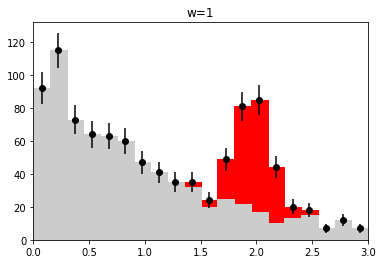

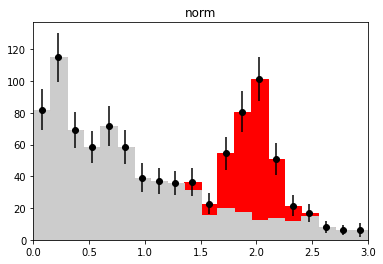

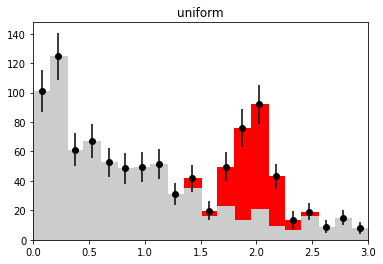

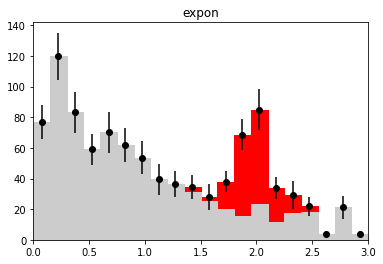

In [2]:
kwd = {"fastmath": True}


@nb.njit(**kwd)
def sum_log(fs, spdf, fb, bpdf):
    return np.sum(np.log(fs * spdf + fb * bpdf))


@nb.njit(**kwd)
def norm_pdf(x, mu, sigma):
    invs = 1.0 / sigma
    z = (x - mu) * invs
    invnorm = 1 / np.sqrt(2 * np.pi) * invs
    return np.exp(-0.5 * z**2) * invnorm


@nb.njit(**kwd)
def nb_erf(x):
    y = np.empty_like(x)
    for i in nb.prange(len(x)):
        y[i] = math.erf(x[i])
    return y


@nb.njit(**kwd)
def norm_cdf(x, mu, sigma):
    invs = 1.0 / (sigma * np.sqrt(2))
    z = (x - mu) * invs
    return 0.5 * (1 + nb_erf(z))


@nb.njit(**kwd)
def expon_pdf(x, lambd):
    inv_lambd = 1.0 / lambd
    return inv_lambd * np.exp(-inv_lambd * x)


@nb.njit(**kwd)
def expon_cdf(x, lambd):
    inv_lambd = 1.0 / lambd
    return 1.0 - np.exp(-inv_lambd * x)


@nb.njit
def cost_lsq(n, mu):
    r = 0.0
    for i in range(len(mu)):
        if n[i] == 0:
            continue
        r += (n[i] - mu[i]) ** 2 / n[i]
    return r


@nb.njit
def _cost_lsq_w(w, wvar, mu):
    r = 0.0
    n = len(mu)
    for i in range(n):
        if wvar[i] == 0:
            continue
        r += (w[i] - mu[i]) ** 2 / wvar[i]
    return r


def cost_lsq_w(w, mu):
    return _cost_lsq_w(w.value, w.variance, mu)


@nb.njit
def cost_ml(n, mu):
    r = 0.0
    for i in range(len(mu)):
        r += mu[i] - n[i] * np.log(mu[i])
    return 2 * r


@nb.njit
def _cost_ml_w(w, wvar, mu):
    # Bohm and Zech, NIMA 748 (2014) 1-6
    r = 0.0
    for i in range(len(mu)):
        if wvar[i] > 0.0:
            if w[i] > 0.0:
                s_inv = w[i] / wvar[i]
                mu_prime = mu[i] * s_inv
                n_prime = w[i] * s_inv
                r += mu_prime - n_prime * np.log(mu_prime)
            else:  # extension
                r += 0.5 * (w[i] - mu[i]) ** 2 / wvar[i]
    return 2 * r


def cost_ml_w(w, mu):
    return _cost_ml_w(w.value, w.variance, mu)


# these distributions are later shifted and scaled to give E[w] = 1 and Var(w) = 1
weight_distributions = [None, np.ones, norm().rvs, uniform().rvs, expon().rvs]
wd_labels = ("no weights", "w=1", "norm", "uniform", "expon")

mu_npts = 1000
signal_fraction = 0.2

par_labels = ("bkg: fraction", "sig: fraction",
              "bkg: lambda", "sig: mu", "sig: sigma")
truth = ((1.0 - signal_fraction), signal_fraction, 1.0, 2.0, 0.2)


def run(wd, wd_label):
    sub_pars = []
    for imc in progressbar(range(nmc), redirect_stdout=True):
        rng = np.random.default_rng(imc)
        all_valid = False
        while not all_valid:
            # sample total number of points from poisson distribution
            npts = rng.poisson(mu_npts)

            # generate background
            b = rng.exponential(truth[2], size=int(truth[0] * npts))

            # generate signal
            s = rng.normal(truth[3], truth[4], size=int(truth[1] * npts))
            x = np.append(b, s)

            if wd is None:
                h = bh.Histogram(bh.axis.Regular(20, 0, 3))
                h.fill(x)
                xe = h.axes[0].edges
                w = h.view()

            else:
                # generate weights
                wi = wd(len(x))
                if np.std(wi) > 0:
                    # wi have mean(wi) = 1 and std(wi) = 1
                    wi = (wi - np.mean(wi)) / np.std(wi) + 1.0
                h = bh.Histogram(bh.axis.Regular(20, 0, 3),
                                 storage=bh.storage.Weight())
                h.fill(x, weight=wi)
                xe = h.axes[0].edges
                w = h.view()

            
            sub_sub_pars = []
            all_valid = True
            for fit_mode in range(2):
                if wd is None:
                    if fit_mode == 0:
                        cost = cost_lsq
                    else:
                        cost = cost_ml
                else:
                    if fit_mode == 0:
                        cost = cost_lsq_w
                    else:
                        cost = cost_ml_w

                def cost_model(par):
                    bkg = expon_cdf(xe, par[2])
                    sig = norm_cdf(xe, par[3], par[4])
                    mu_bkg = par[0] * npts * np.diff(bkg)
                    mu_sig = par[1] * npts * np.diff(sig)
                    res = cost(w, mu_bkg + mu_sig)
                    return res

                m = Minuit.from_array_func(
                    cost_model,
                    truth,
                    limit=((0, None), (0, None),
                           (0, None), None, (0, None)),
                    pedantic=False,
                )

                try:
                    m.migrad()
                    all_valid &= m.valid
                    sub_sub_pars.append(m.np_values())
                except RuntimeError:
                    all_valid = False

        if nmc == 1 and wd is not None:
            plt.figure()
            h_bkg = bh.Histogram(h.axes[0], storage=bh.storage.Weight())
            h_bkg.fill(x[:len(b)], weight=wi[:len(b)])
            h_sig = bh.Histogram(h.axes[0], storage=bh.storage.Weight())
            h_sig.fill(x[len(b):], weight=wi[len(b):])
            plot_stacked(xe, np.array((h_bkg.view().value, h_sig.view().value)),
                         colors=("0.8", "r"), labels=("bkg", "sig"))
            plt.errorbar(h.axes[0].centers, w.value,
                         w.variance ** 0.5, fmt="ok")
            plt.title(wd_label)
            plt.ylim(0, None)
            plt.xlim(xe[0], xe[-1])

        sub_pars.append(sub_sub_pars)
    return sub_pars


# for drawing examples
nmc = 1
for wd, wd_label in zip(weight_distributions, wd_labels):
    run(wd, wd_label)

In [3]:
nmc = 10000
with Pool() as p:
    pars = p.starmap(run, zip(weight_distributions, wd_labels))
pars = np.array(pars)

100% (10000 of 10000) |##################| Elapsed Time: 0:01:15 Time:  0:01:15
100% (10000 of 10000) |##################| Elapsed Time: 0:01:31 Time:  0:01:31
100% (10000 of 10000) |##################| Elapsed Time: 0:01:35 Time:  0:01:35
100% (10000 of 10000) |##################| Elapsed Time: 0:01:35 Time:  0:01:35
100% (10000 of 10000) |##################| Elapsed Time: 0:01:36 Time:  0:01:36


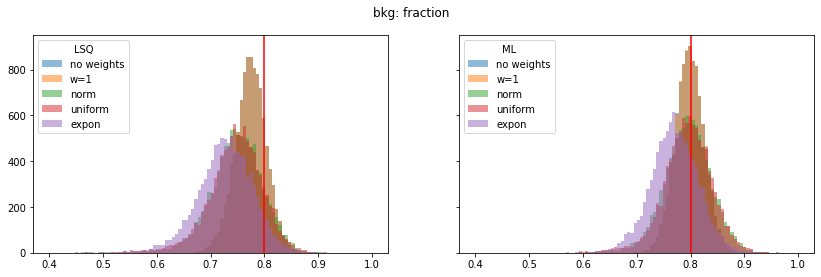

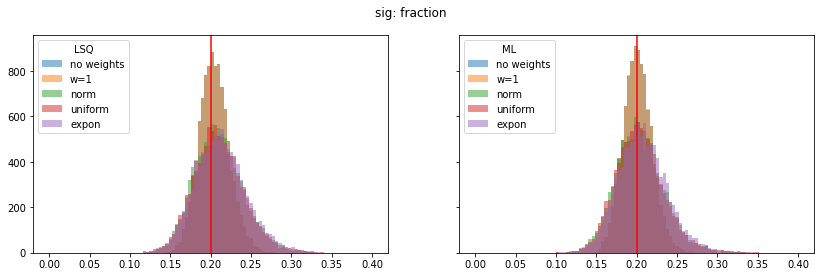

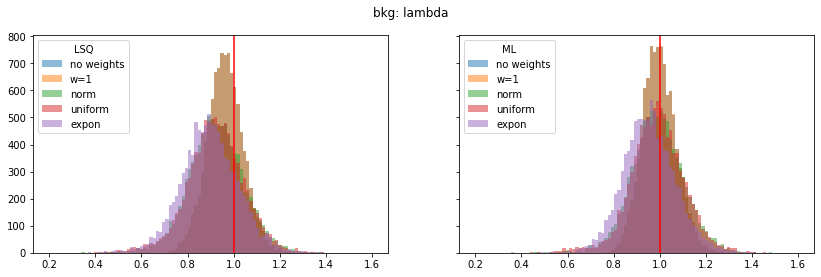

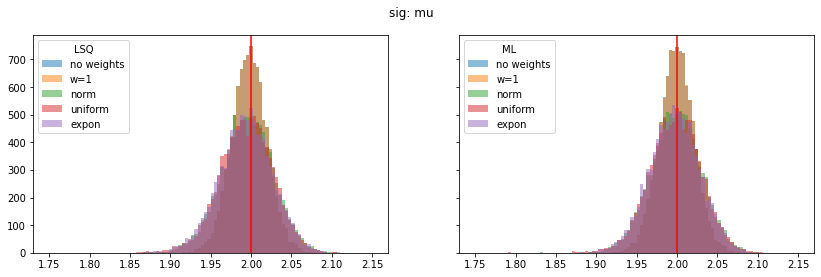

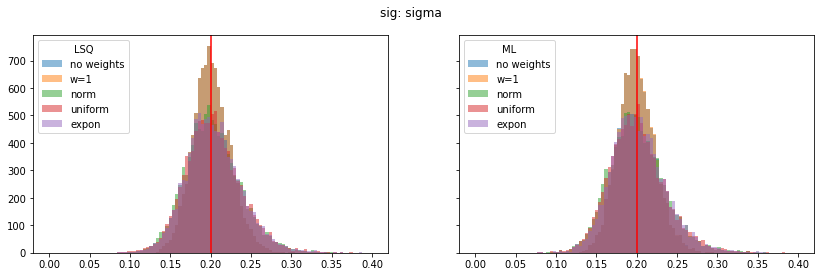

In [4]:
fit_labels = ("LSQ", "ML")
pars_range = ((0.4, 1.0), (0.0, 0.4), (0.2, 1.6), (1.75, 2.15), (0.0, 0.4))
for ipar, (par_label, t) in enumerate(zip(par_labels, truth)):
    fig, ax = plt.subplots(1, 2, figsize=(14, 4), sharex=True, sharey=True)
    plt.suptitle(par_label)
    for iwd, wd_label in enumerate(wd_labels):
        for ifit, fit_label in enumerate(fit_labels):
            plt.sca(ax[ifit])
            p = pars[iwd, :, ifit, ipar]
            plt.hist(p, alpha=0.5, label=wd_label,
                     bins=100, range=pars_range[ipar])
    for label, axi in zip(fit_labels, ax):
        axi.axvline(t, color="r")
        axi.legend(loc="upper left", title=label)

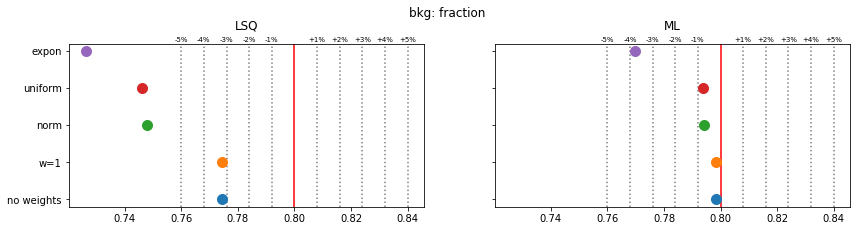

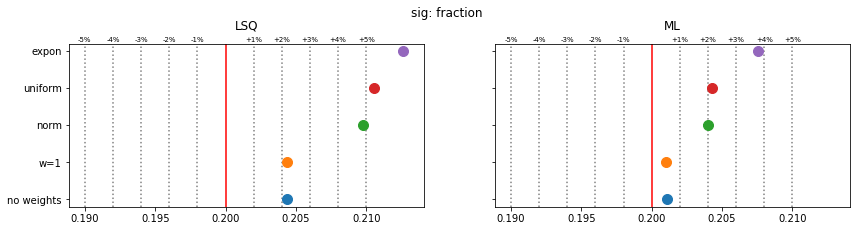

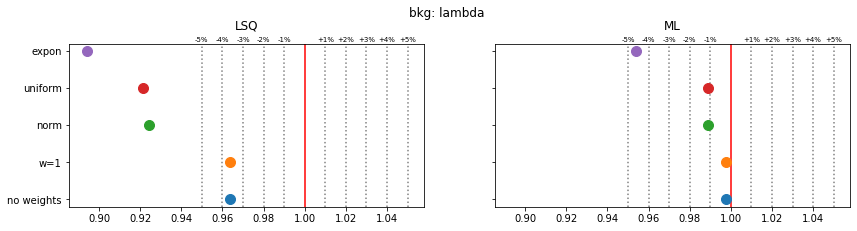

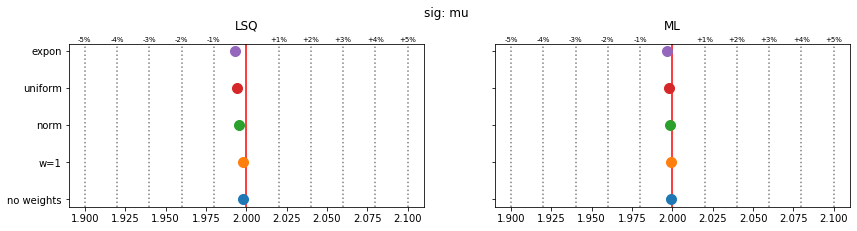

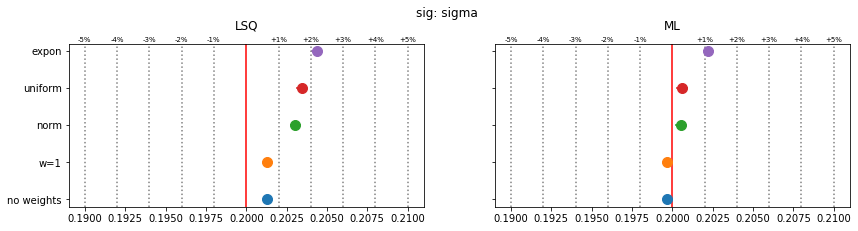

In [5]:
for ipar, (par_label, t) in enumerate(zip(par_labels, truth)):
    fig, ax = plt.subplots(1, 2, figsize=(14, 3), sharex=True, sharey=True)
    plt.suptitle(f"{par_label}", y=1.05)
    for iwd, wd_label in enumerate(wd_labels):
        for ifit in range(2):
            plt.sca(ax[ifit])
            p = pars[iwd, :, ifit, ipar]
            mean = np.mean(p)
            sigma = np.std(p) / len(p) ** 0.5
            plt.errorbar(mean, iwd, 0, sigma, fmt="o", ms=10)
    for fit_label, axi in zip(fit_labels, ax):
        axi.set_title(fit_label, y=1.05)
        axi.axvline(t, color="r")
        for percent in (1, 2, 3, 4, 5):
            dt = t * 1e-2 * percent
            axi.axvline(t - dt, color="0.5", ls=":")
            axi.axvline(t + dt, color="0.5", ls=":")
            axi.text(t + dt, 1.01, f"+{percent}%", transform=axi.get_xaxis_transform(),
                     ha="center", fontsize="x-small")
            axi.text(t - dt, 1.01, f"-{percent}%", transform=axi.get_xaxis_transform(),
                     ha="center", fontsize="x-small")
    plt.sca(ax[0])
    plt.yticks(np.arange(len(wd_labels)), wd_labels)